In [56]:
#---Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
#---Others
from pyimagesearch.nn.conv import LeNet
from imutils import paths
import matplotlib.pyplot
import numpy as np
import argparse 
import imutils
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

### Extract labels and data from the dataset

Get the data from https://www.kaggle.com/c/happy-or-sad-mcgill-comp-598

In [28]:
data = []
labels = []

In [29]:
for imagePath in sorted(list(paths.list_images("G:\\pyimage_univ\\course_6_CNN\\smile_detection\\dataset"))):
    #--Get the data
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width=28)
    data.append(image)

    #--Get the labels
    label= imagePath.split(os.path.sep)[-3] #get the third part of the path where the negative or positive labels is 
    label = "smiling" if label == "positives" else "not_smiling"
    labels.append(label)

In [57]:
cv2.imshow("i", data[1])
cv2.waitKey(0)
cv2.destroyAllWindows()

<AxesSubplot:>

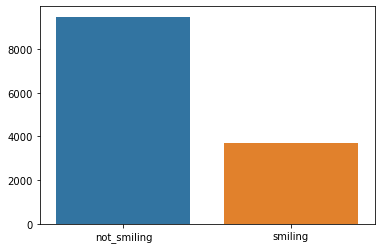

In [6]:
#Check the data distribution
a = [labels.count(i) for i in labels] 
sns.barplot(x=labels, y= a)

### Prepare the data

In [31]:
#--Convert labels to integers
le = LabelEncoder().fit(labels) #initialize the label encoder on the labels
labels= to_categorical(le.transform(labels), 2) #make the labels into a tupe of 0s and 1s

##### There is a problem of imabalanced dataset. Calculating a weight for the "smiling" label is necessary fot the network not to choose "not smiling" more frequently. 

In [32]:
#--Calculate the total number of training images in each class and obtain the class weight
classTotals= labels.sum(axis=0)
classWeight = dict()

In [33]:
#--Loop through the totals and calculate the weights. Put them on a dictionary
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]

In [34]:
classWeight

{0: 1.0, 1: 2.5677507}

##### This weighting implies that our network will treat every instance of “smiling” as 2.56 instances of “not smiling” and helps combat the class imbalance issue by amplifying the per-instance loss by a larger weight when seeing “smiling” examples.

In [36]:
#--Split the data to train and test
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [54]:
#--Don't forget to scale the images. turn them to an array  because they are in a list
trainX = np.array(trainX, dtype=np.float32)/255.0
testX = np.array(testX, dtype=np.float32)/255.0

In [38]:
np.shape(testX)

(2633, 28, 28, 1)

### Train the model

In [55]:
model = LeNet.build(width=28, height=28, depth=1, classes=2)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
H = model.fit(trainX, trainY, validation_data=(testX,testY), class_weight=classWeight, batch_size=64, epochs=30, verbose=1, callbacks=save_best)

Epoch 1/30
165/165 [==============================] - 7s 30ms/step - loss: 0.7420 - accuracy: 0.7439 - val_loss: 0.3288 - val_accuracy: 0.8519

Epoch 00001: accuracy improved from -inf to 0.74392, saving model to G:\pyimage_univ\course_6_CNN\smile_detection\output\best.hdf5
Epoch 2/30
165/165 [==============================] - 4s 27ms/step - loss: 0.4895 - accuracy: 0.8555 - val_loss: 0.4695 - val_accuracy: 0.7786

Epoch 00002: accuracy improved from 0.74392 to 0.85549, saving model to G:\pyimage_univ\course_6_CNN\smile_detection\output\best.hdf5
Epoch 3/30
165/165 [==============================] - 5s 28ms/step - loss: 0.4453 - accuracy: 0.8709 - val_loss: 0.2891 - val_accuracy: 0.8823

Epoch 00003: accuracy improved from 0.85549 to 0.87087, saving model to G:\pyimage_univ\course_6_CNN\smile_detection\output\best.hdf5
Epoch 4/30
165/165 [==============================] - 5s 28ms/step - loss: 0.4132 - accuracy: 0.8845 - val_loss: 0.2614 - val_accuracy: 0.8921

Epoch 00004: accuracy imp

In [59]:
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=le.classes_))

              precision    recall  f1-score   support

 not_smiling       0.95      0.89      0.92      1895
     smiling       0.77      0.89      0.82       738

    accuracy                           0.89      2633
   macro avg       0.86      0.89      0.87      2633
weighted avg       0.90      0.89      0.89      2633



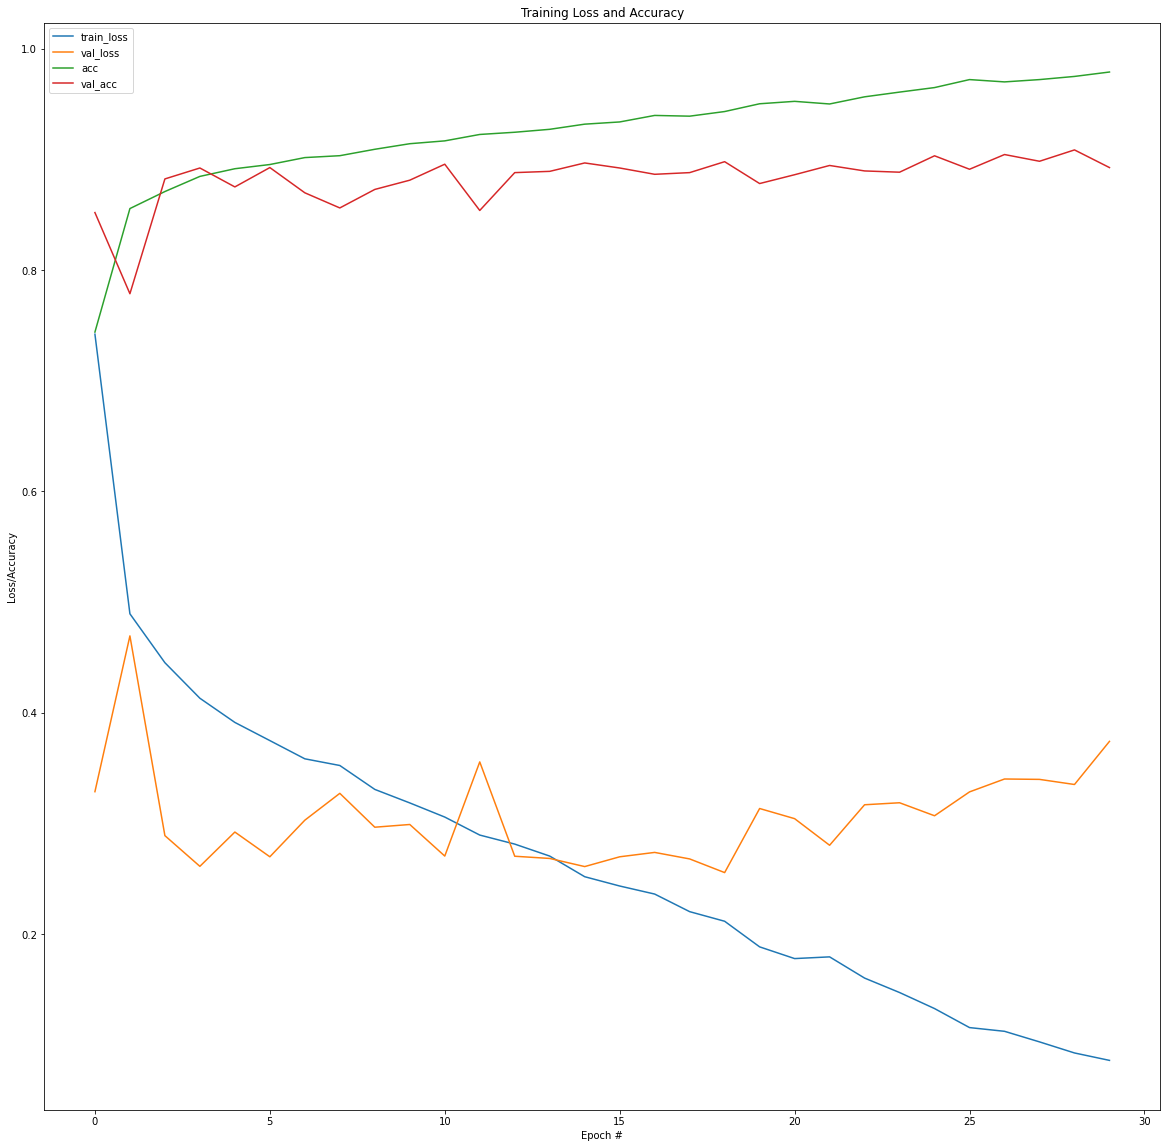

In [61]:
fig = plt.figure(figsize=(20,20))
plt.plot(np.arange(0, 30), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 30), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, 30), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()